In [1]:
import re
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import pearsonr
from datetime import datetime
import seaborn as sns
import sys
sys.path.append('../')
from helpers import *
from analysis_helper import *

data_path = './../../../data'

In [2]:
rb_dir = os.path.join(data_path, 'RateBeer')
exp_categories = get_exp_categories(data_path) + ['expertness_score']
rev_with_scores_rb = pd.read_pickle(os.path.join(rb_dir, 'rev_w_scores.pkl'))
rev_with_scores_rb['date'] = pd.to_datetime(rev_with_scores_rb['date'])
beers_rb = pd.read_csv(os.path.join(rb_dir, 'beers.csv'))
users = pd.read_csv(os.path.join(rb_dir, 'users_RB_clean.csv'))

In [5]:
rev_with_scores_rb.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance_rt', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'review', 'lang_tag', 'stems', 'flavor',
       'mouthfeel', 'brewing', 'technical', 'appearance', 'off_flavors',
       'expertness_score'],
      dtype='object')

In [3]:

scores_for_beer = get_scores_for_beers(rev_with_scores_rb, exp_categories)


In [6]:
scores_for_beer

review_count    flavor           mouthfeel             brewing  \
               count      mean       std      mean       std      mean   
beer_id                                                                  
1               1035  1.858937  1.740796  1.711111  1.420567  0.410628   
2                909  1.452145  1.474141  0.981298  1.148012  0.739274   
3                676  1.963018  1.865109  1.093195  1.241939  0.832840   
4                425  2.075294  1.788057  1.049412  1.179585  0.887059   
5                562  2.556940  2.058277  1.217082  1.310533  0.882562   
...              ...       ...       ...       ...       ...       ...   
536430             2  4.500000  0.707107  0.500000  0.707107  0.000000   
536431             3  3.333333  1.527525  1.666667  2.081666  0.333333   
536456             5  2.400000  0.547723  1.200000  1.303840  0.200000   
536465             2  3.500000  2.121320  0.000000  0.000000  0.500000   
536467             2  3.500000  0.707107  1.500000  2.121320  0.500000   

                  technical           appearance           off_flavors  \
              std      mean       std       mean       std        mean   
beer_id                                                                  
1        0.606607  0.571981  0.854721   1.163285  1.232775    0.101449   
2        0.808278  0.595160  0.854516   1.427943  1.223184    0.171617   
3        0.852109  0.807692  0.982061   1.449704  1.217946    0.218935   
4        0.827845  0.738824  0.905967   1.609412  1.256270    0.225882   
5        0.829760  0.679715  0.931092   1.829181  1.370430    0.229537   
...           ...       ...       ...        ...       ...         ...   
536430   0.000000  0.500000  0.707107   2.000000  1.414214    0.000000   
536431   0.577350  0.666667  0.577350   0.666667  0.577350    0.000000   
536456   0.447214  0.400000  0.547723   1.800000  1.303840    0.200000   
536465   0.707107  0.500000  0.707107   0.500000  0.707107    0.000000   
536467   0.707107  1.000000  0.000000   1.000000  0.000000    0.000000   

                  expertness_score            
              std             mean       std  
beer_id                                       
1        0.352317         5.817391  4.433311  
2        0.458915         5.367437  3.828550  
3        0.483196         6.365385  4.287233  
4        0.537103         6.585882  4.031455  
5        0.502027         7.395018  4.506740  
...           ...              ...       ...  
536430   0.000000         7.500000  0.707107  
536431   0.000000         6.666667  3.511885  
536456   0.447214         6.200000  2.167948  
536465   0.000000         5.000000  1.414214  
536467   0.000000         7.500000  3.535534  

[277840 rows x 15 columns]

In [6]:
mean_scores_beer = get_mean_scores_beer(rev_with_scores_rb, exp_categories)
complete_beer = pd.merge(beers_rb, mean_scores_beer, on='beer_id')

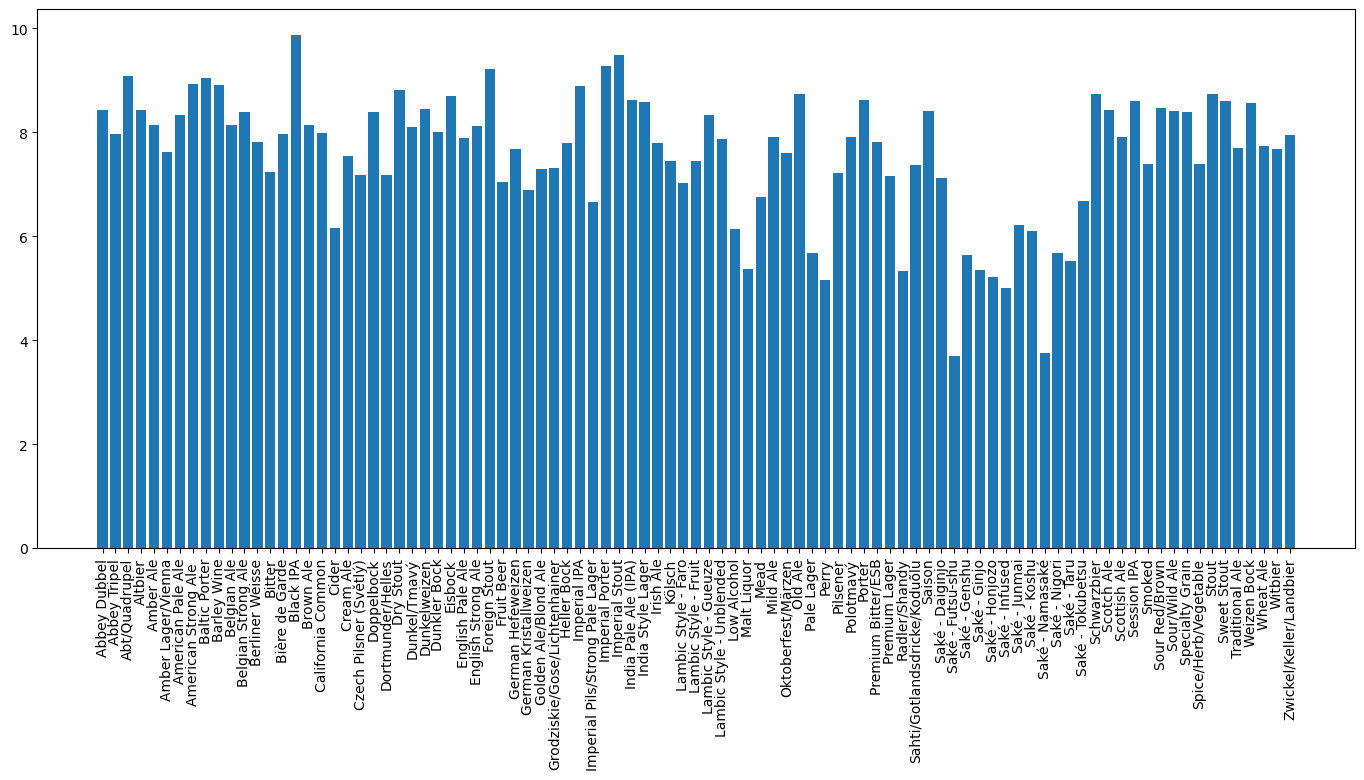

In [7]:
beer_gr = get_beer_gr(complete_beer, exp_categories)
fig  = plt.figure(figsize=(17,7))
plt.bar(beer_gr.index, beer_gr['expertness_score'])

plt.xticks(rotation=90)
plt.show()

In [8]:
mean_scores_beer['review_count'].corr(mean_scores_beer['expertness_score'])

-0.012310210627004058

<Axes: >

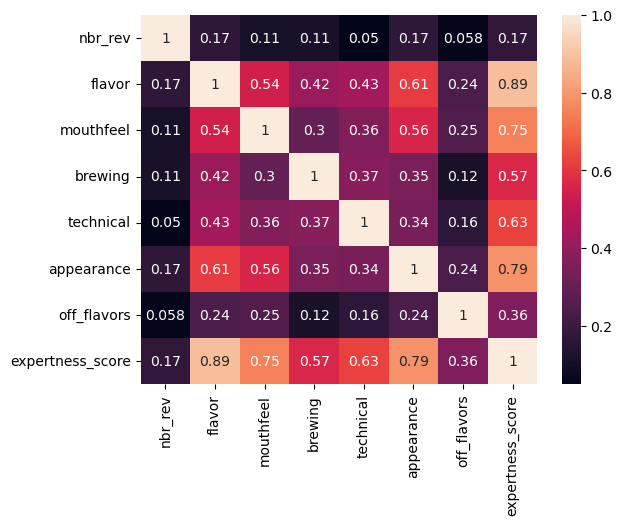

In [9]:
user_rb = get_users_stats(rev_with_scores_rb, exp_categories, user_id='user_name')
sns.heatmap(user_rb.corr(), annot=True)

<Axes: >

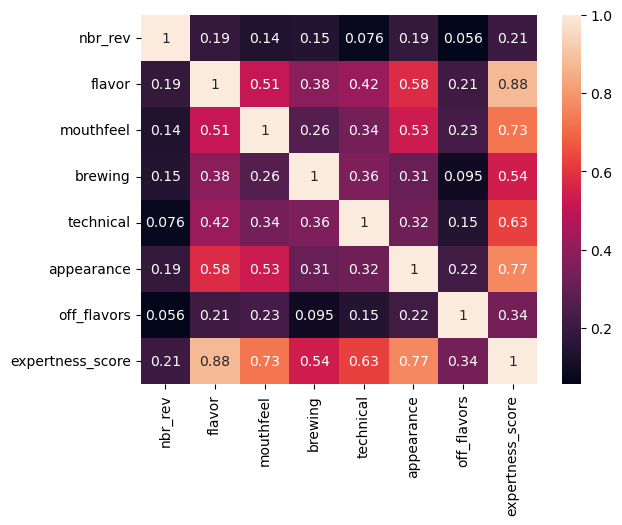

In [10]:
sns.heatmap(user_rb[user_rb['nbr_rev']<200].corr(), annot=True)

In [11]:
pearsonr(user_rb['expertness_score'], user_rb['nbr_rev'])

PearsonRResult(statistic=0.1727353234241635, pvalue=0.0)

In [12]:
# Normalizes review dates to the first review date for each user, setting their first review as day zero.
rev_zero_date= joined_date_zero(rev_with_scores_rb, user_id='user_name')
# Standardize the reviews score through the mean and the std of the scores for that particular beer 
rev_std = standardize(rev_zero_date, scores_for_beer.reset_index(), exp_categories)

result = rev_std.groupby('user_name').apply(corr_and_count, include_groups=False)

result = result.dropna()
result

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pe

,correlation,p_value,total_count
user_name,,,
000pete1983,-0.248472,0.634962,6.0
007lund,-0.140849,0.218697,78.0
00cobraR,-0.093262,0.004378,932.0
00german00,-0.537930,0.108738,10.0
0110x011,0.037179,0.899588,14.0
...,...,...,...
zygomatic99,-0.017632,0.952294,14.0
zymosis,-0.153274,0.570898,16.0
zyster99,0.063262,0.822773,15.0


In [13]:
result[(result['total_count'] > 20) & (result['total_count'] < 500)]['correlation'].mean()

0.020905817366025967

In [14]:
result['correlation'].mean()

0.015519406207463077

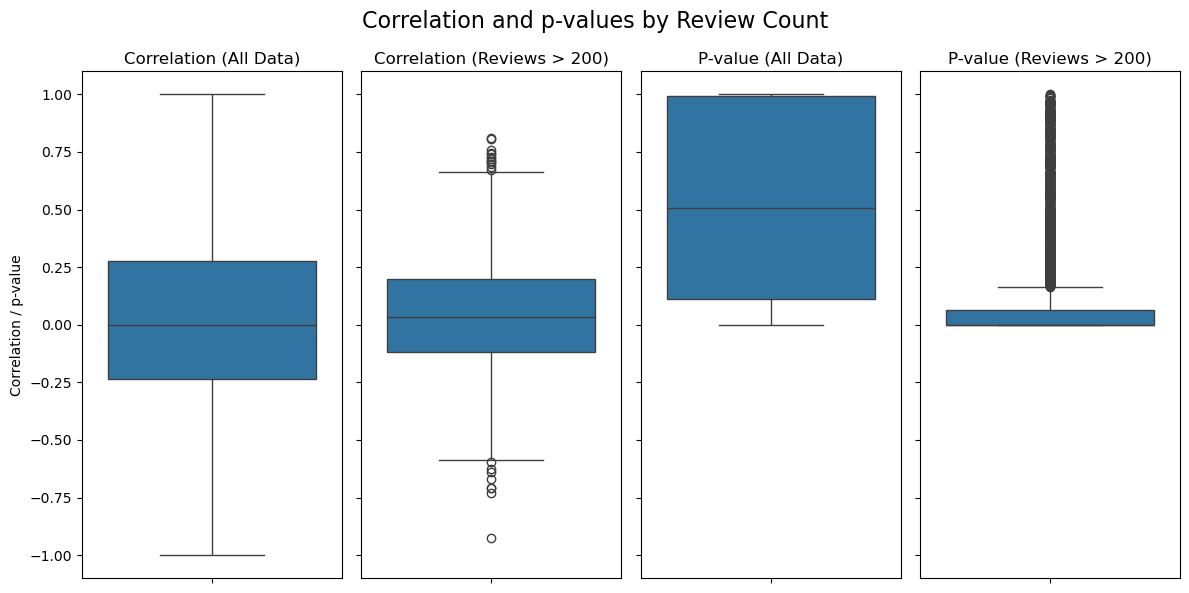

In [15]:
plot_corr_and_pvalue(result)

In [16]:
len(users[users['nbr_ratings']>200])

4425

In [18]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, user_id='user_name', nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=100)
rev_exp_zero_date= joined_date_zero(rev_of_exp, user_id='user_name')

rev_exp_std = standardize(rev_exp_zero_date, scores_for_beer.reset_index(), exp_categories)
result = rev_exp_std.groupby('user_name').apply(corr_and_count, include_groups=False)

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pe

In [19]:
result = result.dropna()

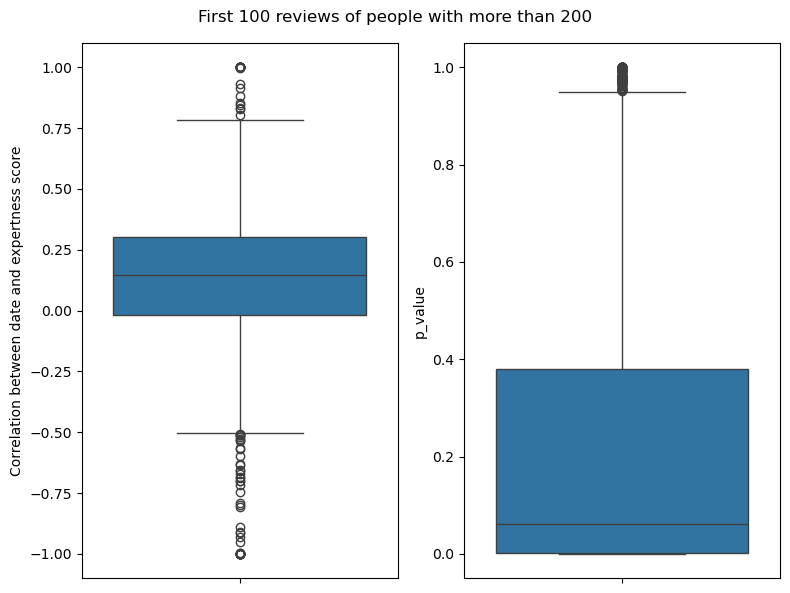

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6)) 

fig.suptitle('First 100 reviews of people with more than 200')

sns.boxplot(y=result['correlation'], ax=axes[0])

axes[0].set_ylabel("Correlation between date and expertness score")

sns.boxplot(y=result['p_value'], ax=axes[1])
axes[1].set_ylabel("p_value")

plt.tight_layout()  
plt.show()


In [21]:
result['correlation'].mean()

0.13605246020681802

In [ ]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, user_id='user_name', nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=5)

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


Text(0.5, 1.0, 'Mean of the score (standardized) of the first 5 reviews of people with more than 200')

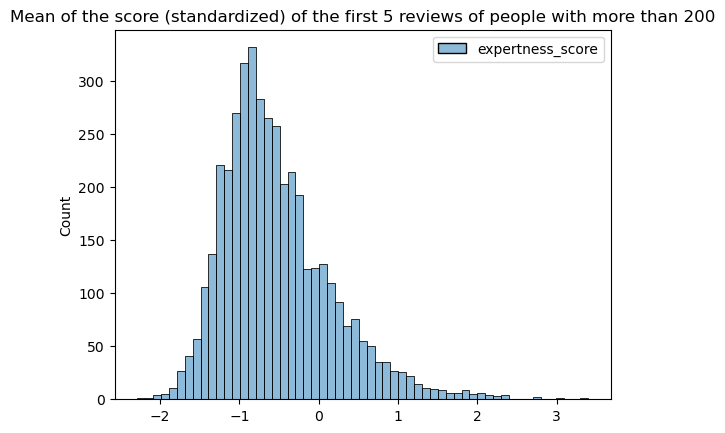

In [23]:
rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), exp_categories)
rev_exp_std_grouped = rev_exp_std.groupby('user_name')[['expertness_score']].agg('mean')
sns.histplot(rev_exp_std_grouped)
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200')

In [24]:
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score']<-0.5].index

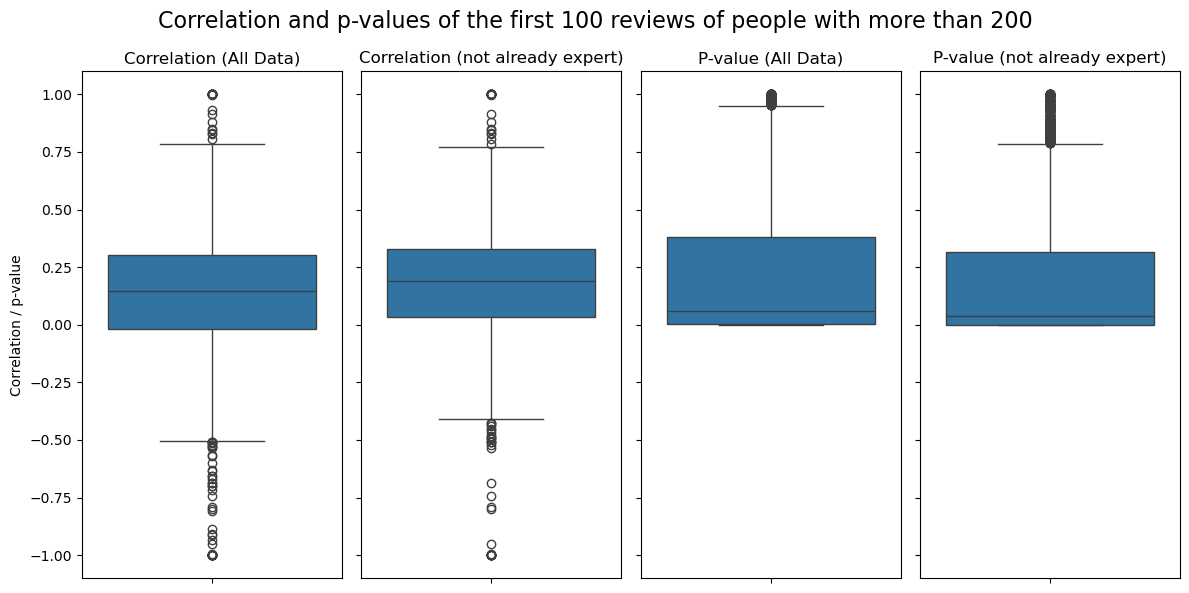

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle("Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [26]:
result[result.index.isin(no_already_experts)].correlation.mean()

0.1790060779377274

In [27]:
result[result.index.isin(no_already_experts)].p_value.describe()

count    2.484000e+03
mean     2.005014e-01
std      2.852197e-01
min      2.067706e-26
25%      8.056928e-04
50%      3.909731e-02
75%      3.145009e-01
max      1.000000e+00
Name: p_value, dtype: float64

__Using and incremental count instead of the date__

In [28]:

rev_exp_std = standardize(rev_with_scores_rb, scores_for_beer.reset_index(), exp_categories)


/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


In [29]:
result_rep_date = rev_exp_std.groupby('user_name').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:138: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))


In [30]:
len(result_rep_date)

37552

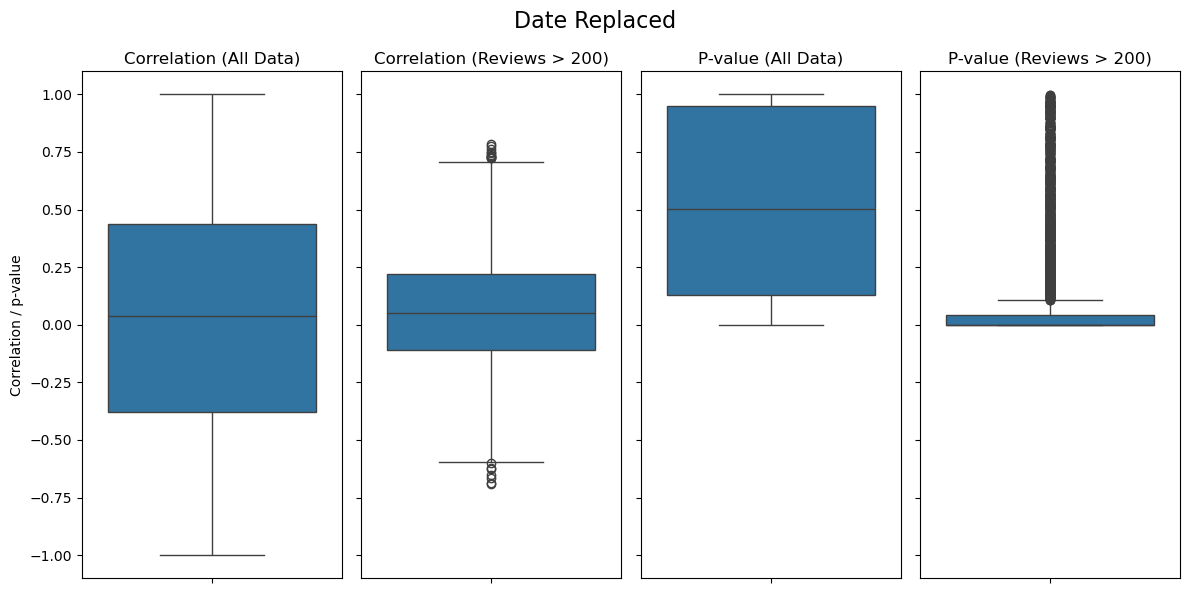

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle('Date Replaced', fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (Reviews > 200)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['p_value'], ax=axes[3])
axes[3].set_title("P-value (Reviews > 200)")


plt.tight_layout()  
plt.show()

In [32]:
result_rep_date[(result_rep_date['total_count'] > 20) & (result_rep_date['total_count'] < 500)]['correlation'].mean()

0.04595073995303983

In [33]:
result_rep_date['correlation'].mean()

0.023548083373233167

In [34]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, user_id='user_name', nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=100)


rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), exp_categories)
result_rep_date = rev_exp_std.groupby('user_name').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


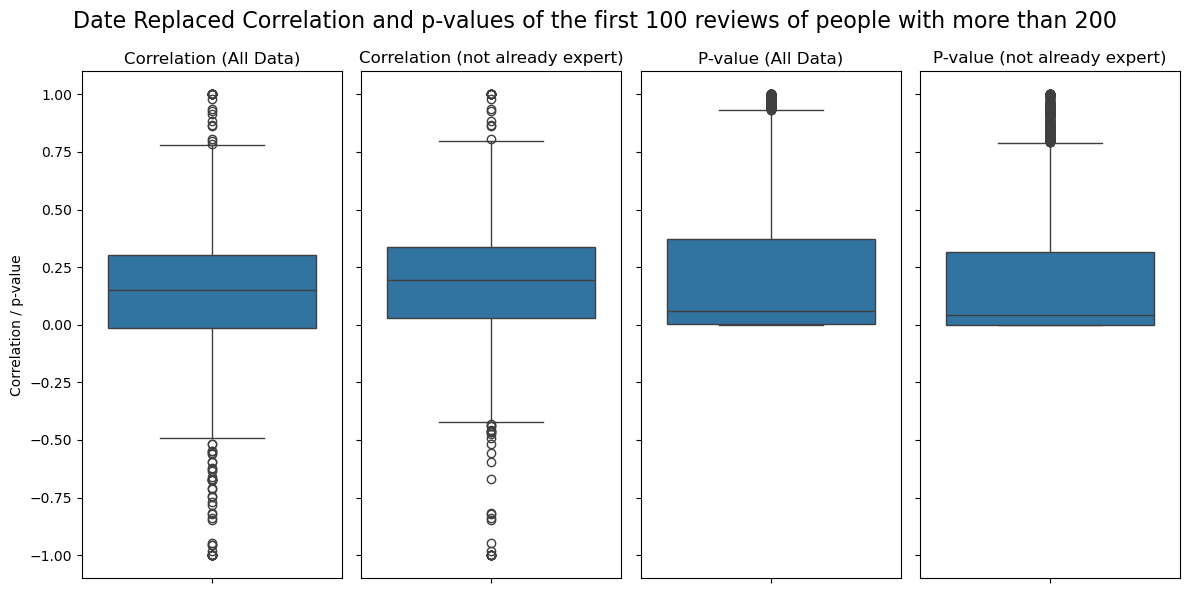

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True) 


fig.suptitle("Date Replaced Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [36]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].correlation.mean()

0.1827389347232627

In [37]:
result_rep_date.correlation.mean()

0.14044120241350472

In [38]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].p_value.describe()

count    2.493000e+03
mean     2.017383e-01
std      2.890836e-01
min      6.860383e-24
25%      6.510233e-04
50%      4.104249e-02
75%      3.168128e-01
max      1.000000e+00
Name: p_value, dtype: float64

## Avg user evolution

In [7]:
rev_exp_std = standardize(rev_with_scores_rb, scores_for_beer.reset_index(), exp_categories) 

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_analysis/analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


Text(0.5, 1.0, 'Mean of the score (standardized) of the first 5 reviews of people with more than 200')

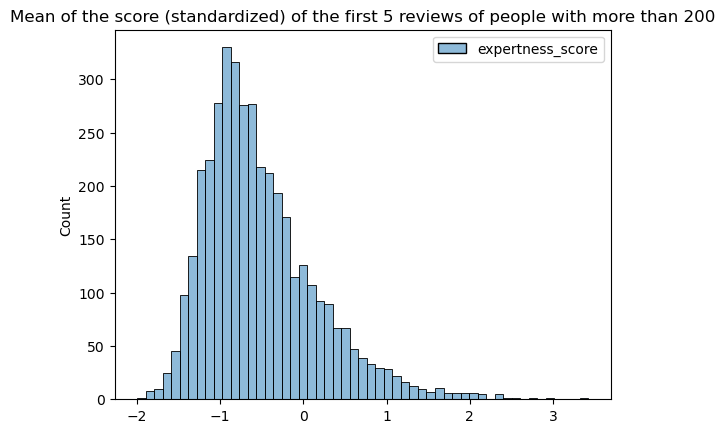

In [29]:
rev_of_exp = review_of_experts(rev_exp_std, users, user_id='user_name', nbr_rev=200)
first_rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=5)
rev_exp_std_grouped = first_rev_of_exp.groupby('user_name')[['expertness_score']].agg('mean')
sns.histplot(rev_exp_std_grouped, color='hls')
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200')

In [30]:
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score'] < -0.5].index
len(no_already_experts)

2376

In [36]:
already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score'] > 0.5].index
len(already_experts)

330

In [103]:
sel_rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=50)
result_rep_date = sel_rev_of_exp.groupby('user_name').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

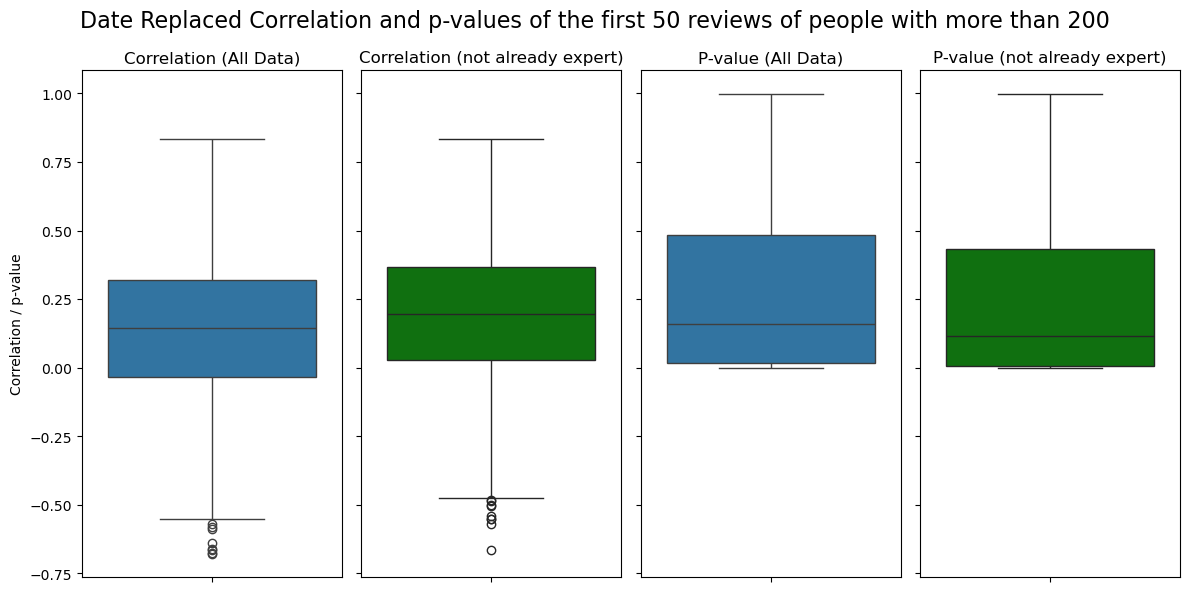

In [104]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True) 

fig.suptitle("Date Replaced Correlation and p-values of the first 50 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1], color = 'green')
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['p_value'], ax=axes[3], color = 'green')
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [105]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].correlation.median()

0.1951866241524487

In [106]:
result_rep_date.correlation.median()

0.14631168476956655

In [14]:
rev_of_exp = review_of_experts(rev_exp_std, users, user_id='user_name', nbr_rev=200)
first_rev_of_exp = first_reviews(rev_of_exp, user_id='user_name', max=200)

In [ ]:
rev_no_al_exp = first_rev_of_exp[first_rev_of_exp.user_name.isin(no_already_experts)]
rev_no_al_exp = rev_no_al_exp.sort_values(by=['user_name', 'date'])

# Create incremental numbers for each user
rev_no_al_exp['rev_nbr'] = rev_no_al_exp.groupby('user_name').cumcount() 

In [16]:
col_to_keep = ['rev_nbr']+ exp_categories
avg_no_al_exp = rev_no_al_exp[col_to_keep].groupby('rev_nbr').agg(['mean', 'std', 'count'])

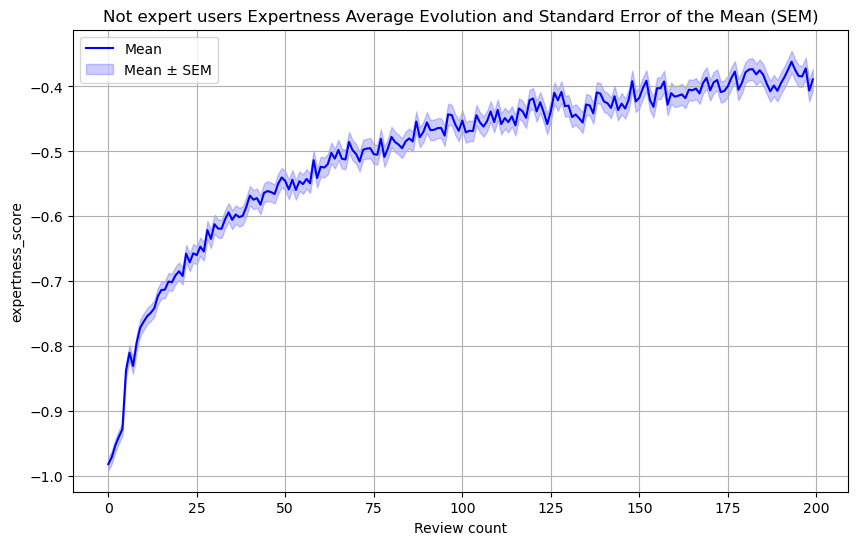

In [22]:
# Compute SEM
avg_no_al_exp[('expertness_score', 'sem')] = avg_no_al_exp[('expertness_score', 'std')] / np.sqrt(avg_no_al_exp[('expertness_score', 'count')])

# Plot mean and SEM
plt.figure(figsize=(10, 6))

# Plot the mean
plt.plot(avg_no_al_exp.index, avg_no_al_exp['expertness_score']['mean'], label='Mean', color='blue')

# Plot the SEM as a shaded area
plt.fill_between(
    avg_no_al_exp.index,
    avg_no_al_exp['expertness_score']['mean'] - avg_no_al_exp['expertness_score']['sem'],
    avg_no_al_exp['expertness_score']['mean'] + avg_no_al_exp['expertness_score']['sem'],
    color='blue',
    alpha=0.2,
    label='Mean ± SEM'
)

# Formatting the plot
plt.title('Not expert users Expertness Average Evolution and Standard Error of the Mean (SEM)')
plt.xlabel('Review count')
plt.ylabel('expertness_score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# English and non English countries / expert and non expert

In [ ]:
complete_exp_rev = pd.merge(first_rev_of_exp, users[['user_name', 'location']], on='user_name')
complete_exp_rev = complete_exp_rev.sort_values(by=['user_name', 'date'])

# Create incremental numbers for each user
complete_exp_rev['rev_nbr'] = complete_exp_rev.groupby('user_name').cumcount() 
complete_exp_rev['location'] = complete_exp_rev['location'].str.replace(r'United States, .*', 'United States', regex=True)

In [90]:
no_eng_countries = ['Italy', 'Spain', 'Germany', 'France', 'Poland', 'Belgium', 'Estonia', 'Austria', 'Croatia', 'Hungary', 'Switzerland']

eng_countries = ['United States', 'England', 'Northern Ireland', 'Australia', 'Canada']

In [91]:
print(len(complete_exp_rev[complete_exp_rev['location'].isin(no_eng_countries)& complete_exp_rev['user_name'].isin(already_experts)])/200)
print(len(complete_exp_rev[complete_exp_rev['location'].isin(eng_countries) & complete_exp_rev['user_name'].isin(already_experts)])/200)
print(len(complete_exp_rev[complete_exp_rev['location'].isin(no_eng_countries)& complete_exp_rev['user_name'].isin(no_already_experts)])/200)
print(len(complete_exp_rev[complete_exp_rev['location'].isin(eng_countries) & complete_exp_rev['user_name'].isin(no_already_experts)])/200)

37.0
230.0
183.0
1630.975


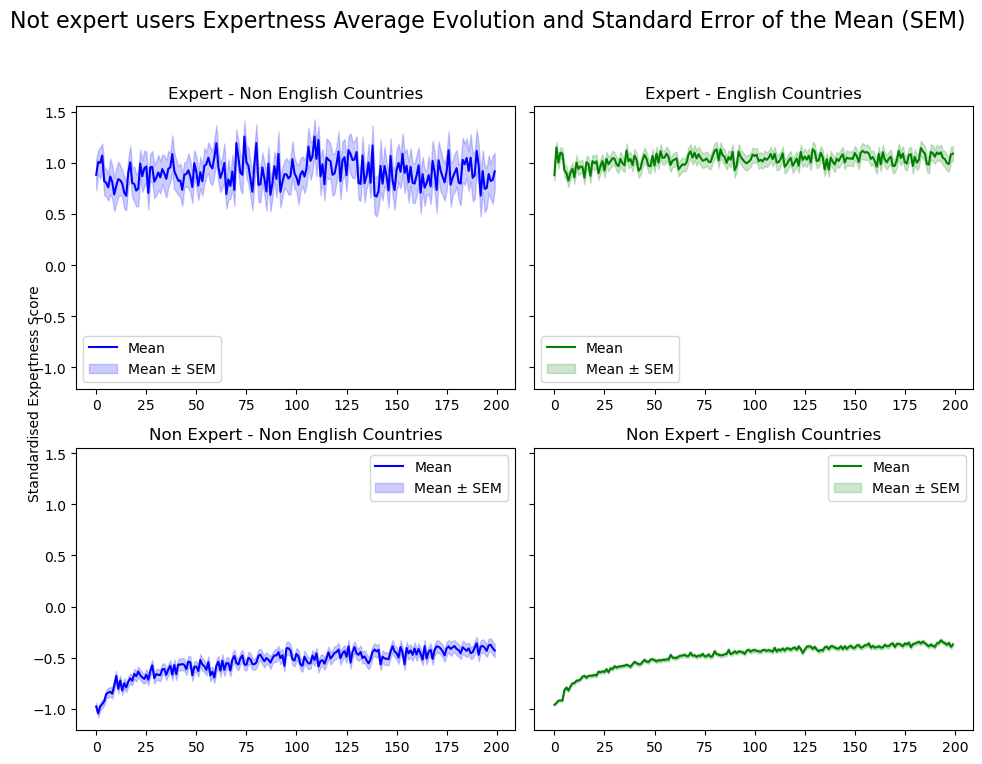

In [98]:
col_to_keep = ['rev_nbr'] + exp_categories

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

fig.suptitle(
    "Not expert users Expertness Average Evolution and Standard Error of the Mean (SEM)", 
    fontsize=16
)

for i, ax in enumerate(axes.flatten()): 
    if i == 0:
        rev_selected = complete_exp_rev[
            complete_exp_rev['location'].isin(no_eng_countries) & 
            complete_exp_rev['user_name'].isin(already_experts)
        ]
        sub_title = "Expert - Non English Countries"
    elif i == 1:
        rev_selected = complete_exp_rev[
            complete_exp_rev['location'].isin(eng_countries) & 
            complete_exp_rev['user_name'].isin(already_experts)
        ]
        sub_title = "Expert - English Countries"
    elif i == 2:
        rev_selected = complete_exp_rev[
            complete_exp_rev['location'].isin(no_eng_countries) & 
            complete_exp_rev['user_name'].isin(no_already_experts)
        ]
        sub_title = "Non Expert - Non English Countries"
    else:
        rev_selected = complete_exp_rev[
            complete_exp_rev['location'].isin(eng_countries) & 
            complete_exp_rev['user_name'].isin(no_already_experts)
        ]
        sub_title = "Non Expert - English Countries"

    color = 'blue' if i % 2 == 0 else 'green'

    avg_rev = rev_selected[col_to_keep].groupby('rev_nbr').agg(['mean', 'std', 'count'])
    avg_rev[('expertness_score', 'sem')] = avg_rev[('expertness_score', 'std')] / np.sqrt(
        avg_rev[('expertness_score', 'count')]
    )

    ax.plot(
        avg_rev.index, 
        avg_rev['expertness_score']['mean'], 
        label='Mean', 
        color=color
    )
    ax.fill_between(
        avg_rev.index,
        avg_rev['expertness_score']['mean'] - avg_rev['expertness_score']['sem'],
        avg_rev['expertness_score']['mean'] + avg_rev['expertness_score']['sem'],
        color=color,
        alpha=0.2,
        label='Mean ± SEM'
    )

    ax.set_title(sub_title)
    ax.legend()

fig.text(0.04, 0.5, 'Standardised Expertness Score', va='center', rotation='vertical')

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])  # Add space for suptitle and y-axis label
plt.show()
